In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

# Read in and process data

Load already processed dataframes from the csv files

In [449]:
cellpose_file = "cellpose_results/cellpose_run04_240427113411.csv"
food_file = "FoodSeg103_results/food_run04_240428133857.csv"
cellpose_df = pd.read_csv(f'{cellpose_file[:-4]}_processed.csv')
food_df = pd.read_csv(f'{food_file[:-4]}_processed.csv')

for df in [cellpose_df, food_df]:
    # Show shape, the first rows and the mean values for each scribbles bin
    print(df.shape)
    display(df[:15])
    display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

(60480, 22)


,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,...,accuracy,image,ground truth,scribbles,prediction,diff_to_ilastik,layers,scalings,min_class_pix_labelled,max_class_pix_labelled
0,0,convpaint_l-0_s-1,all,0.010,w1_run04,101577,94519,17,9,8,...,0.781107,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.045350,0,1,8,9
1,0,convpaint_l-0_s-1-2,all,0.010,w1_run04,101577,94519,17,9,8,...,0.749368,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.077090,0,1-2,8,9
2,0,convpaint_l-0_s-1-2-4,all,0.010,w1_run04,101577,94519,17,9,8,...,0.777277,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.049180,0,1-2-4,8,9
3,0,convpaint_l-0_s-1-2-4-8,all,0.010,w1_run04,101577,94519,17,9,8,...,0.693854,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.132603,0,1-2-4-8,8,9
4,0,convpaint_l-0-2_s-1,all,0.010,w1_run04,101577,94519,17,9,8,...,0.691299,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.135158,0-2,1,8,9
5,0,convpaint_l-0-2_s-1-2,all,0.010,w1_run04,101577,94519,17,9,8,...,0.677061,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.149396,0-2,1-2,8,9
6,0,convpaint_l-0-2_s-1-2-4,all,0.010,w1_run04,101577,94519,17,9,8,...,0.674333,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.152124,0-2,1-2-4,8,9
7,0,convpaint_l-0-2_s-1-2-4-8,all,0.010,w1_run04,101577,94519,17,9,8,...,0.682518,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.143940,0-2,1-2-4-8,8,9
8,0,convpaint_l-0-2-5_s-1,all,0.010,w1_run04,101577,94519,17,9,8,...,0.672783,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.153675,0-2-5,1,8,9
9,0,convpaint_l-0-2-5_s-1-2,all,0.010,w1_run04,101577,94519,17,9,8,...,0.684231,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_c...,-0.142226,0-2-5,1-2,8,9


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.010,0.008876,15.894444,0.749858
0.025,0.022330,41.655556,0.808502
0.050,0.045392,84.290741,0.838074
0.100,0.092680,171.809259,0.862656
0.250,0.239392,441.694444,0.884562
0.500,0.485309,893.875926,0.894470
1.000,0.978887,1802.096296,0.901637
10.000,10.102773,18443.907407,0.911592


(19320, 18)


,img_num,prediction type,scribbles mode,scribbles bin,suffix,max_class_pix_gt,min_class_pix_gt,pix_labelled,max_class_pix_labelled,min_class_pix_labelled,pix_in_img,perc. labelled,accuracy,scribbles,prediction,diff_to_ilastik,layers,scalings
0,0,convpaint_l-0_s-1,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.808197,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.012253,0,1
1,0,convpaint_l-0_s-1-2,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.811732,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.015788,0,1-2
2,0,convpaint_l-0_s-1-2-4,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.817520,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.021576,0,1-2-4
3,0,convpaint_l-0_s-1-2-4-8,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.684402,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,-0.111542,0,1-2-4-8
4,0,convpaint_l-0-2_s-1,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.818532,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.022588,0-2,1
5,0,convpaint_l-0-2_s-1-2,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.819077,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.023132,0-2,1-2
6,0,convpaint_l-0-2_s-1-2-4,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.804565,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.008621,0-2,1-2-4
7,0,convpaint_l-0-2_s-1-2-4-8,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.684820,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,-0.111125,0-2,1-2-4-8
8,0,convpaint_l-0-2-5_s-1,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.824849,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.028905,0-2-5,1
9,0,convpaint_l-0-2-5_s-1-2,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.801910,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...,0.005966,0-2-5,1-2


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.25,0.247791,392.450000,0.651148
1.00,0.973125,1573.015217,0.761077
5.00,4.958578,8008.602174,0.869250


Load raw dataframes and process them

In [ ]:
# # Load the dataframes from the csv files
# cellpose_file = "cellpose_results/cellpose_run04_240427113411.csv"
# food_file = "FoodSeg103_results/food_run04_240428133857.csv"
# cellpose_df = pd.read_csv(cellpose_file)
# food_df = pd.read_csv(food_file)

# # Replace the scribbles values with the corresponding bin values (some scribbles were widened afterwards)
# cellpose_df['scribbles bin'] = cellpose_df['scribbles bin'].replace({1.25: 10})
# food_df['scribbles bin'] = food_df['scribbles bin'].replace({0.058: 0.25, 0.25: 1, 1.4: 5})

# # For cellpose, also add the min and max pix labbelled columns
# cellpose_df.loc[:,'min_class_pix_labelled'] = cellpose_df[['class_1_pix_labelled', 'class_2_pix_labelled']].min(axis=1)#.astype(int)
# cellpose_df.loc[:,'max_class_pix_labelled'] = cellpose_df[['class_1_pix_labelled', 'class_2_pix_labelled']].max(axis=1)#.astype(int)

# # Process further and show the dataframes
# for df in [cellpose_df, food_df]:
#     # df['prediction type'] = df['prediction type'].replace({'convpaint_l-0_s-1-2': 'convpaint (default)'})
    
#     # Add a column for the difference to the ilastik prediction accuracy
#     for scr in df['scribbles'].unique():
#         acc_il = df.loc[(df['scribbles'] == scr) & (df['prediction type'] == "ilastik"), "accuracy"].values[0]
#         df.loc[(df['scribbles'] == scr), "diff_to_ilastik"] = df.loc[(df['scribbles'] == scr), "accuracy"] - acc_il

#     # Add columns for the layers and scalings (extracted from the prediction type tag)
#     df['layers'] = df['prediction type'].str.extract(r'l-(\d+-?\d*-?\d*)')
#     df['scalings'] = df['prediction type'].str.extract(r's-(\d+-?\d*-?\d*-?\d*)')
    
#     # Show shape, the first rows and the mean values for each scribbles bin
#     print(df.shape)
#     display(df[:15])
#     display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

Save processed dataframes to csv files

In [ ]:
# cellpose_df.to_csv(f'{cellpose_file[:-4]}_processed.csv', index=False)
# food_df.to_csv(f'{food_file[:-4]}_processed.csv', index=False)

# Check distribution of accuracies among the dataset

Text(0, 0.5, 'Accuracy')

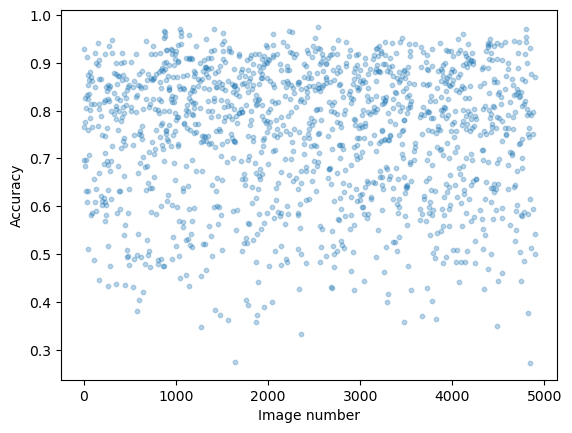

In [450]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

# Filter if necessary
df_filtered = df[df['prediction type'] == 'convpaint_l-0-2-5_s-1-2-4-8']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.scatter(df_filtered['img_num'], df_filtered['accuracy'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel('Accuracy')

# Check distribution of the differences among the dataset

Text(0, 0.5, 'Accuracy diff.')

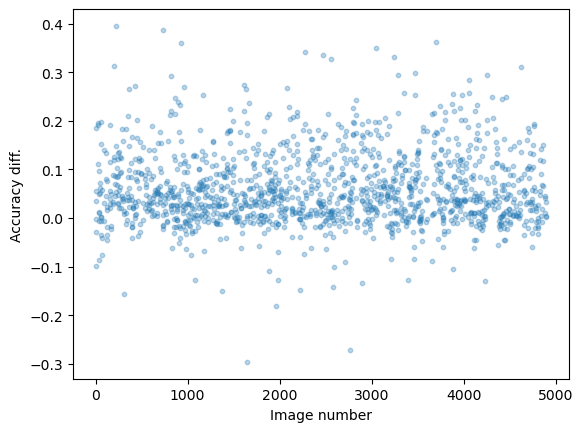

In [451]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

# Filter if necessary
df_filtered = df[df['prediction type'] == 'convpaint_l-0-2-5_s-1-2-4-8']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.scatter(x = df_filtered['img_num'], y = df_filtered['diff_to_ilastik'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel('Accuracy diff.')

Check in which cases the differences are the strongest

In [461]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

# Filter if necessary
# df_filtered = df[df['prediction type'] == 'convpaint_l-0_s-1-2-4-8']
df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# List the 10 worst predictions (compared to ilastik)
df_filtered.sort_values(by="diff_to_ilastik", ascending=True)[0:10]

C:\Users\roman\AppData\Local\Temp\ipykernel_18344\421803913.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[(df['scribbles bin'] == 1)]


,img_num,prediction type,scribbles mode,scribbles bin,suffix,max_class_pix_gt,min_class_pix_gt,pix_labelled,max_class_pix_labelled,min_class_pix_labelled,pix_in_img,perc. labelled,accuracy,scribbles,prediction,diff_to_ilastik,layers,scalings
7199,1824,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,41707,2739,873,64663,36,65536,1.332092,0.460770,/mnt/imaging.data/rschwob/food_run04/1824_scri...,/mnt/imaging.data/rschwob/food_run04/1824_conv...,-0.175507,0,1-2-4-8
2243,608,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,26417,6663,657,64879,66,65536,1.002502,0.575012,/mnt/imaging.data/rschwob/food_run04/0608_scri...,/mnt/imaging.data/rschwob/food_run04/0608_conv...,-0.167496,0,1-2-4-8
16271,4072,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,58872,3353,1027,110903,36,111930,0.917538,0.538453,/mnt/imaging.data/rschwob/food_run04/4072_scri...,/mnt/imaging.data/rschwob/food_run04/4072_conv...,-0.131359,0,1-2-4-8
563,152,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,69404,6318,1260,110670,58,111930,1.125704,0.718851,/mnt/imaging.data/rschwob/food_run04/0152_scri...,/mnt/imaging.data/rschwob/food_run04/0152_conv...,-0.120557,0,1-2-4-8
17699,4432,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,60669,21264,1251,110679,178,111930,1.117663,0.693675,/mnt/imaging.data/rschwob/food_run04/4432_scri...,/mnt/imaging.data/rschwob/food_run04/4432_conv...,-0.115671,0,1-2-4-8
7409,1872,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,37892,2148,695,64841,24,65536,1.060486,0.526718,/mnt/imaging.data/rschwob/food_run04/1872_scri...,/mnt/imaging.data/rschwob/food_run04/1872_conv...,-0.111694,0,1-2-4-8
8543,2136,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,126777,21164,1721,194887,193,196608,0.875346,0.606649,/mnt/imaging.data/rschwob/food_run04/2136_scri...,/mnt/imaging.data/rschwob/food_run04/2136_conv...,-0.105993,0,1-2-4-8
2033,544,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,63880,14132,2060,194548,126,196608,1.047770,0.598414,/mnt/imaging.data/rschwob/food_run04/0544_scri...,/mnt/imaging.data/rschwob/food_run04/0544_conv...,-0.103887,0,1-2-4-8
7031,1784,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,103395,7547,1866,194742,75,196608,0.949097,0.663086,/mnt/imaging.data/rschwob/food_run04/1784_scri...,/mnt/imaging.data/rschwob/food_run04/1784_conv...,-0.097356,0,1-2-4-8
15053,3784,convpaint_l-0_s-1-2-4-8,all,1.0,w3_run04,37098,14079,658,64878,115,65536,1.004028,0.698196,/mnt/imaging.data/rschwob/food_run04/3784_scri...,/mnt/imaging.data/rschwob/food_run04/3784_conv...,-0.091995,0,1-2-4-8


### Correlation between pixels labelled and difference

Cellpose: Pixels labelled in one or the other class (not working for FoodSeg103 with multiple classes)

C:\Users\roman\AppData\Local\Temp\ipykernel_18344\3191274574.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[(df['scribbles bin'] == 1)]


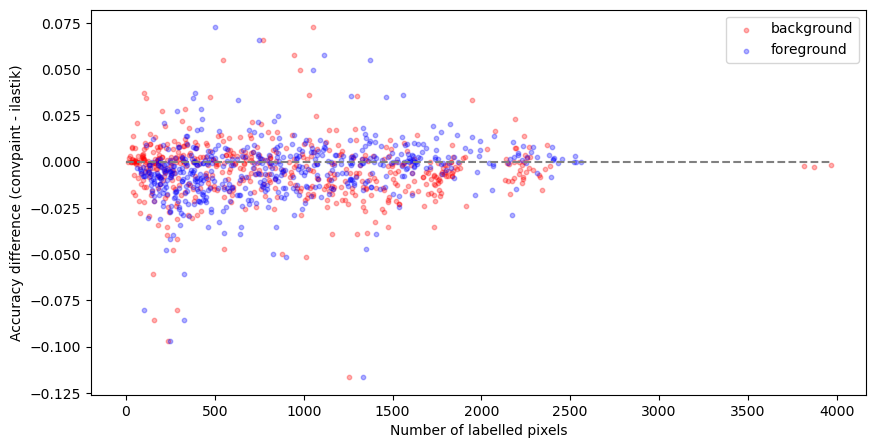

In [458]:
# Define which dataframe to use
df = cellpose_df.copy()

# Filter if necessary
df_filtered = df[df['prediction type'] == 'convpaint_l-0-2-5_s-1-2-4-8']
df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_filtered["class_1_pix_labelled"], df_filtered["diff_to_ilastik"], alpha=0.3, s=10, c="red", label="background")
plt.scatter(df_filtered["class_2_pix_labelled"], df_filtered["diff_to_ilastik"], alpha=0.3, s=10, c = "blue", label="foreground")
plt.xlabel("Number of labelled pixels")
# plt.xscale("log")
plt.hlines(0, 0, np.max([np.max(df_filtered["class_1_pix_labelled"]), np.max(df_filtered["class_1_pix_labelled"])]), colors='grey', linestyles='dashed')
plt.ylabel("Accuracy difference (convpaint - ilastik)")
plt.legend()

Minimum/maximum pixels labelled among classes

C:\Users\roman\AppData\Local\Temp\ipykernel_18344\3341739418.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[(df['scribbles bin'] == 1)]


Text(0, 0.5, 'Accuracy difference (convpaint - ilastik)')

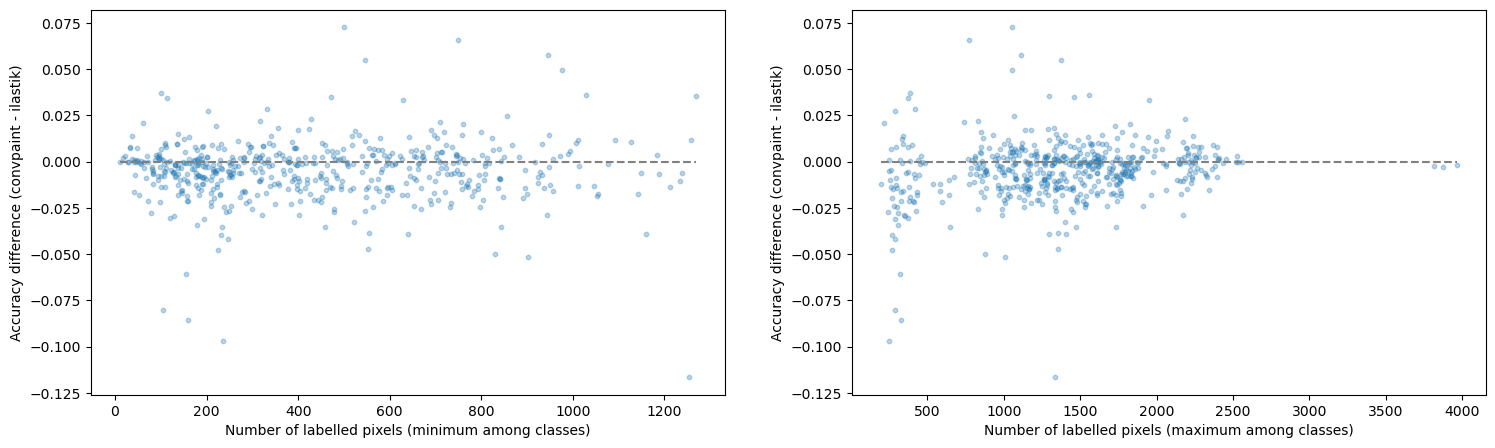

In [459]:
# Define which dataframe to use
df = cellpose_df.copy()
# df = food_df.copy()

# Filter if necessary
df_filtered = df[df['prediction type'] == 'convpaint_l-0-2-5_s-1-2-4-8']
df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
ax1.scatter(x = df_filtered['min_class_pix_labelled'], y = df_filtered['diff_to_ilastik'], alpha=0.3, s=10)
ax1.set_xlabel("Number of labelled pixels (minimum among classes)")
# ax1.set_xscale("log")
ax1.hlines(0, np.min(df_filtered['min_class_pix_labelled']), np.max(df_filtered['min_class_pix_labelled']), colors='grey', linestyles='dashed')
ax1.set_ylabel("Accuracy difference (convpaint - ilastik)")
ax2.scatter(x = df_filtered['max_class_pix_labelled'], y = df_filtered['diff_to_ilastik'], alpha=0.3, s=10)
ax2.set_xlabel("Number of labelled pixels (maximum among classes)")
# ax2.set_xscale("log")
ax2.hlines(0, np.min(df_filtered['max_class_pix_labelled']), np.max(df_filtered['max_class_pix_labelled']), colors='grey', linestyles='dashed')
ax2.set_ylabel("Accuracy difference (convpaint - ilastik)")

### Correlation between the resolution (# pixels) and the difference

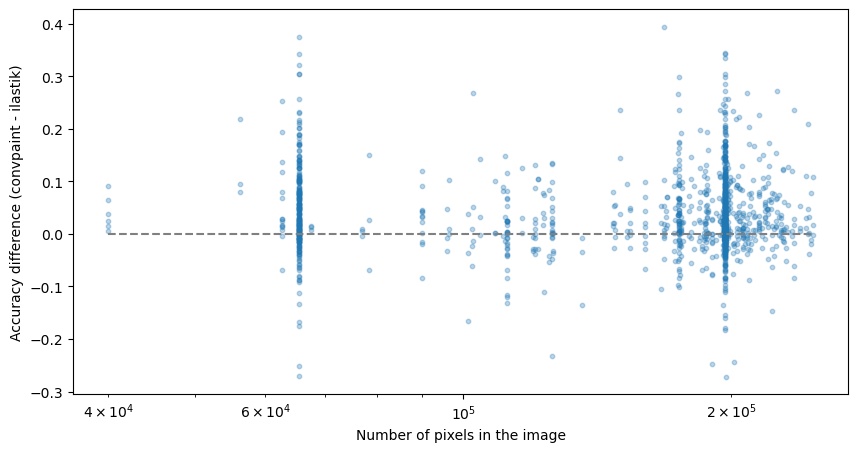

In [460]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

# Filter if necessary
df_filtered = df[df['prediction type'] == 'convpaint_l-0_s-1-2-4-8']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_filtered["pix_in_img"], df_filtered["diff_to_ilastik"], alpha=0.3, s=10)
plt.xlabel("Number of pixels in the image")
plt.ylabel("Accuracy difference (convpaint - ilastik)")
plt.hlines(0, np.min(df_filtered["pix_in_img"]), np.max(df_filtered["pix_in_img"]), colors='grey', linestyles='dashed')
plt.xscale("log")

# Compare bins

### Difference to Ilastik

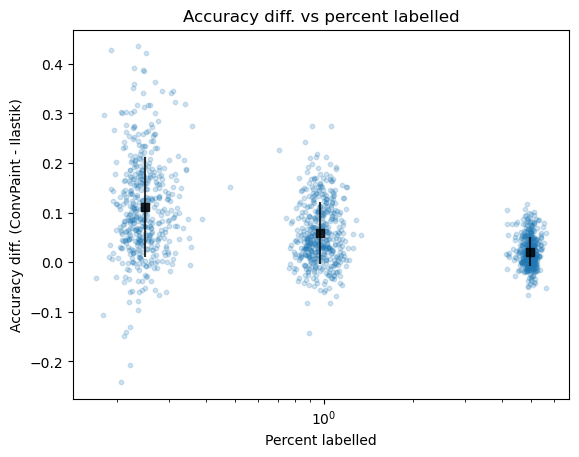

In [462]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

# Filter if necessary
df_filtered = df[df['prediction type'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.scatter(df_filtered['perc. labelled'], df_filtered['diff_to_ilastik'], alpha=0.2, s=10)
df_grouped = df_filtered.groupby('scribbles bin').agg({'diff_to_ilastik': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['diff_to_ilastik']['mean'], yerr=df_grouped['diff_to_ilastik']['std'], fmt='s', c='black', alpha=0.8)
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy diff. (ConvPaint - Ilastik)')
plt.title(f'Accuracy diff. vs percent labelled')
plt.show()

### Accuracy of different models on separate dotplots side-by-side

In [463]:
def plot_accuracy_vs_perc_labelled(df, pred_to_show="convpaint", plt_ax=None, **kwargs):
    if plt_ax is None:
        plt_ax = plt.subplots(1, 1)[1]
    
    if pred_to_show:
        df_exact = df[df['prediction type'] == pred_to_show]
        if len(df_exact) == 0:
            df_filtered = df[df['prediction type'].str.contains(pred_to_show)]
        else:
            df_filtered = df_exact

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered['accuracy'], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({'accuracy': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel('Accuracy')
    plt_ax.set_title(f'Accuracy diff. vs percent labelled {pred_to_show}')

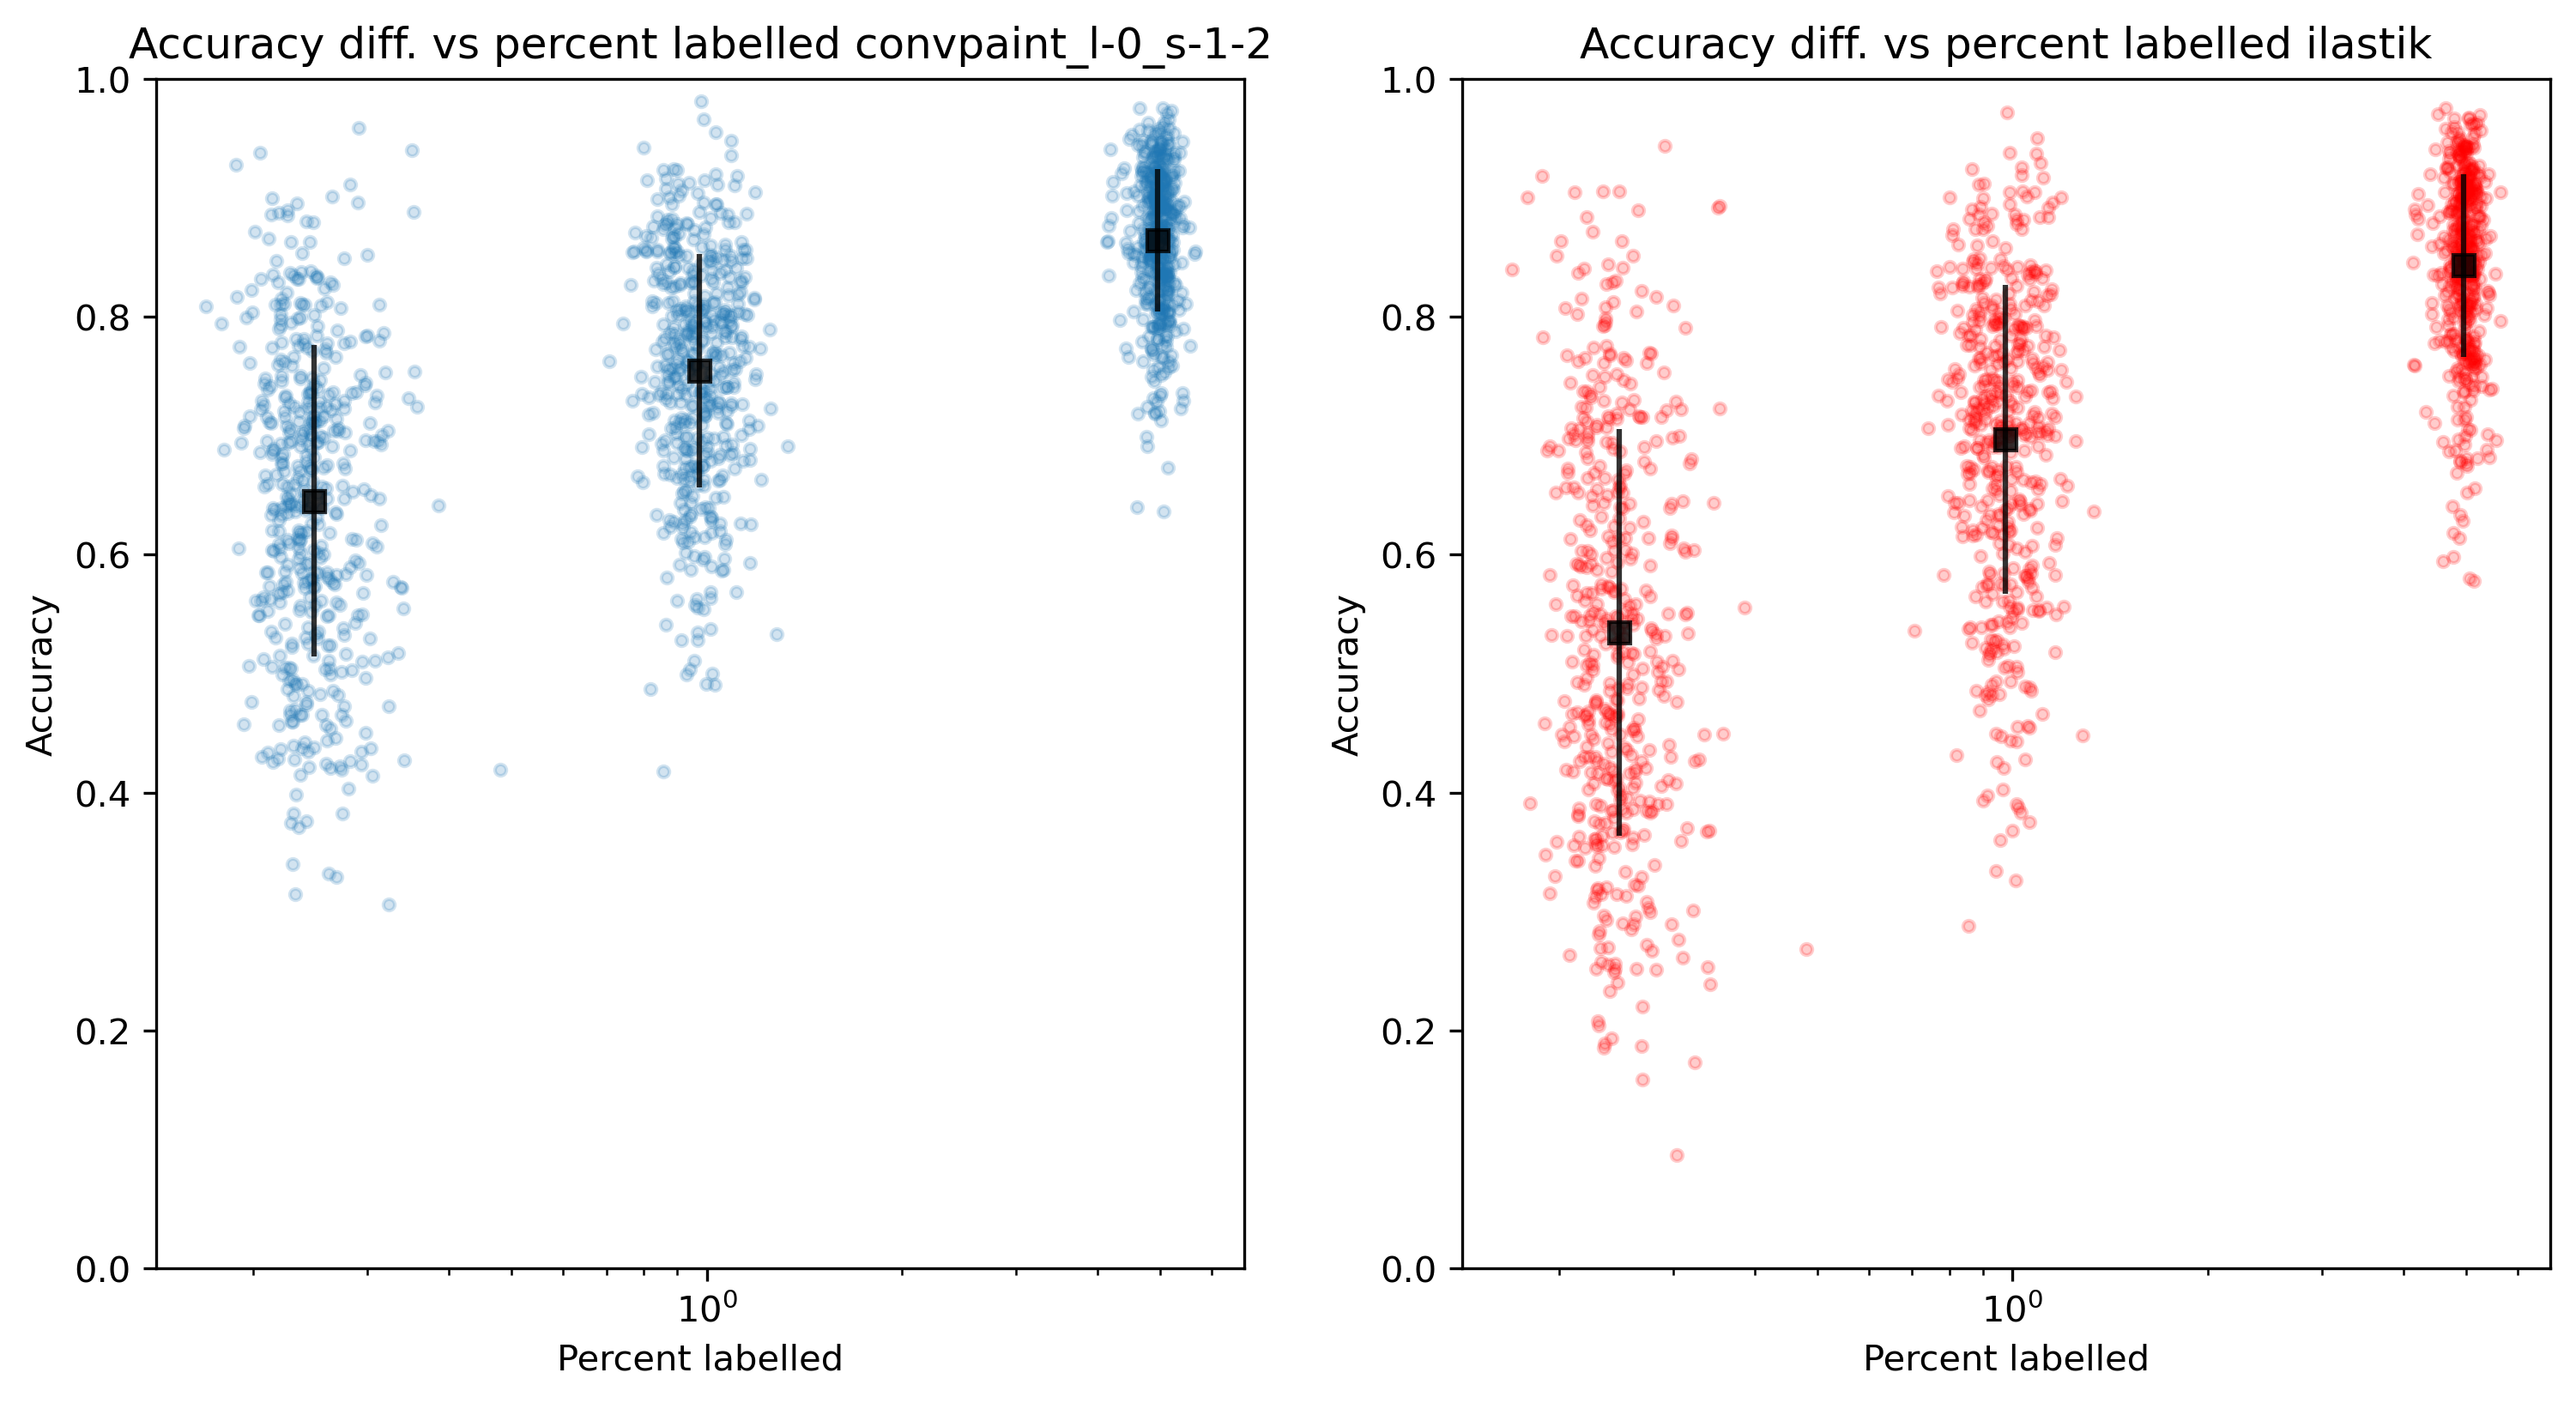

In [92]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

pred_type_1 = 'convpaint_l-0_s-1-2'
pred_type_2 = 'ilastik'

# Plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
fig.set_dpi(300)
plot_accuracy_vs_perc_labelled(df, pred_type_1, plt_ax=ax[0])
plot_accuracy_vs_perc_labelled(df, pred_type_2, plt_ax=ax[1], c='red')
# plt.savefig('results/accuracy_vs_perc_labelled.pdf', dpi=300)
plt.show()

### Accuracy of different models on same dotplot

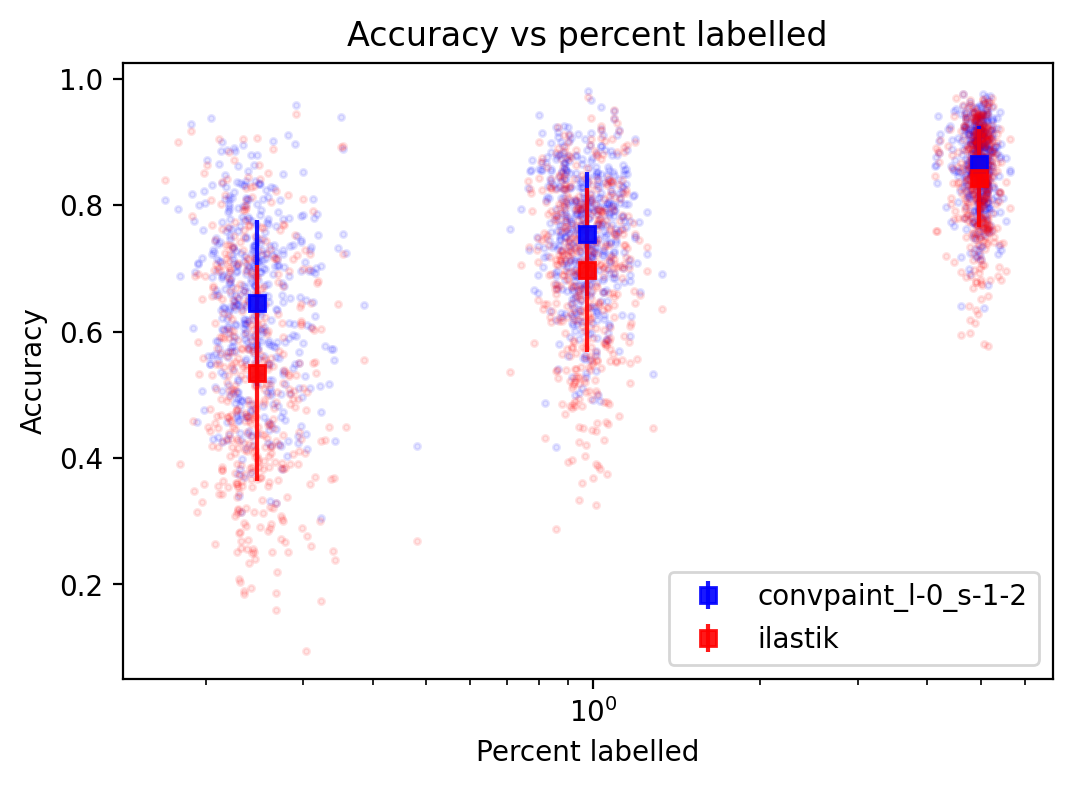

In [464]:
# Define which dataframe to use
# df = cellpose_df.copy()
df = food_df.copy()

# Filter
pred_type_1 = 'convpaint_l-0_s-1-2'
pred_type_2 = 'ilastik'
df_filtered_1 = df[df['prediction type'] == pred_type_1]
df_filtered_2 = df[df['prediction type'] == pred_type_2]

# Plot accuracy vs percent labelled
plt.figure(figsize=(6,4),dpi=200)

# ADD FIRST PLOT
# Scatterplot
plt.scatter(df_filtered_1['perc. labelled'], df_filtered_1['accuracy'], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_filtered_1.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='blue', alpha=0.9, label=pred_type_1)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD SECOND PLOT
# Scatterplot
plt.scatter(df_filtered_2['perc. labelled'], df_filtered_2['accuracy'], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_filtered_2.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='red', alpha=0.9, label=pred_type_2)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.legend()
plt.show()

### VIOLINPLOT (accuracies)

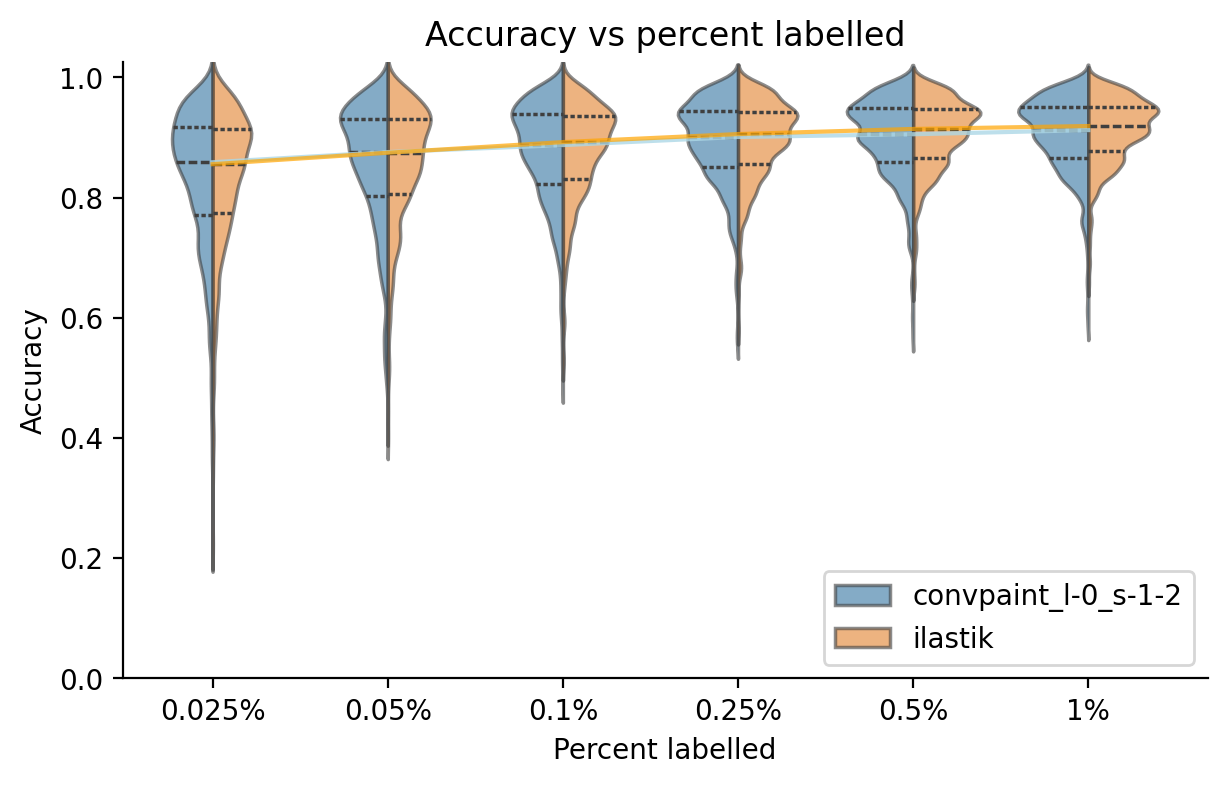

In [105]:
# Define which dataframe to use
df = cellpose_df.copy()
# df = food_df.copy()

# Optionally filter before comparing prediciton types (e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]

# Filter for the prediciton types to use
pred_type_1 = 'convpaint_l-0_s-1-2'
pred_type_2 = 'ilastik'
df_filtered_1 = df[df['prediction type'] == pred_type_1]
df_filtered_2 = df[df['prediction type'] == pred_type_2]
df_both = pd.concat([df_filtered_1, df_filtered_2])

# Plot accuracy vs percent labelled (violin plot)
plt.figure(figsize=(7, 4), dpi=200)

# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y='accuracy', data=df_both, hue='prediction type', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_filtered_1_grouped = df_filtered_1.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
df_filtered_2_grouped = df_filtered_2.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
plt.plot(x_positions, df_filtered_1_grouped['accuracy'], color='lightblue', alpha=0.8)
plt.plot(x_positions, df_filtered_2_grouped['accuracy'], color='orange', alpha=0.7)
# original colours: lightblue, orange

# Set some parameters
x_labels = [f"{int(x) if int(x)==x else x}%" for x in df_filtered_1_grouped['scribbles bin']]

plt.ylim(0, 1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.legend(loc='lower right')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')

# Show or save the plot
# plt.savefig("cellpose_results/pred04_convpaint-vs-ilastik_acc-vs-lab.pdf", format='pdf')
plt.show()


# Compare VGG16 layer/scaling combos

In [469]:
# Define which dataframe to use
df = cellpose_df.copy()
# df = food_df.copy()

# Optionally filter before comparing prediciton types (e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# For each model, create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction type'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ilastik = [single_bin_df[single_bin_df['prediction type'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction type'].str.contains('dino')] for single_bin_df in bin_df_list]

In [466]:
# Check if the lists are composed as intended
# bin_df_list_conv[-1][bin_df_list_conv[-1]['img_num'] == 0]
# bin_df_list_ilastik[0][bin_df_list_ilastik[0]['img_num'] < 2]
# bin_df_list_dino[0][bin_df_list_dino[0]['img_num'] < 2]

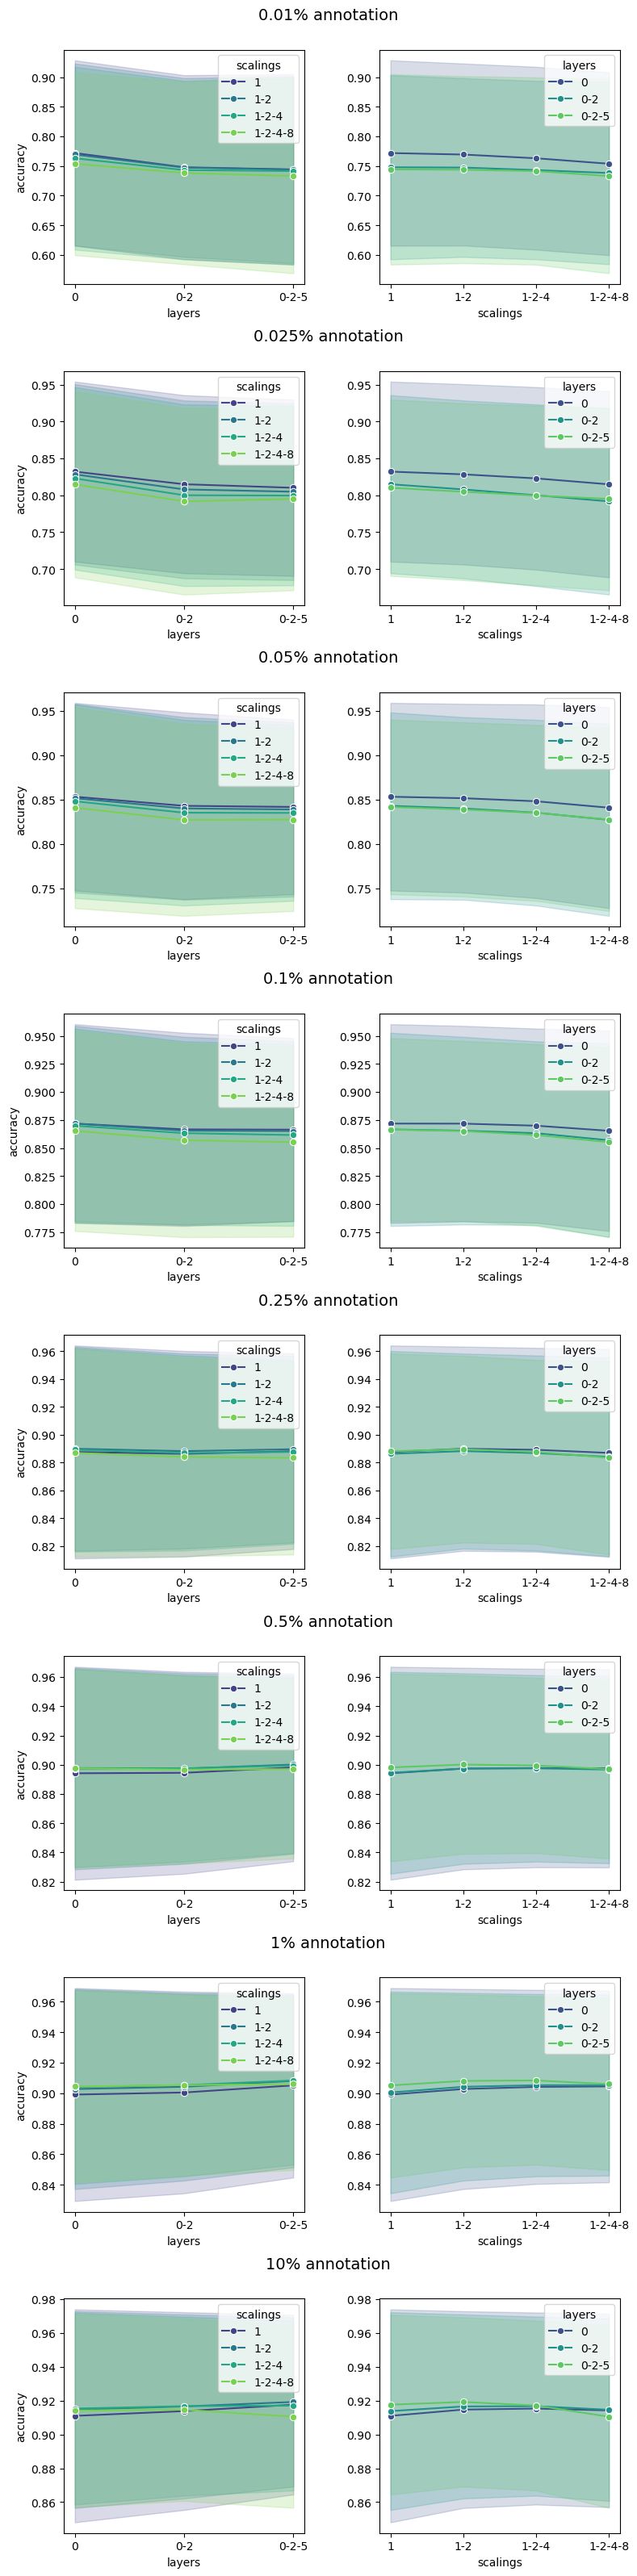

In [470]:
num_df = len(bin_df_list_conv)
fig, ax = plt.subplots(num_df, 2)

fig.set_size_inches(8, 4 * num_df)
fig.set_dpi(100)

for i, df in enumerate(bin_df_list_conv):
    row = ax[i]
    sns.lineplot(x='layers', y='accuracy', data=df, hue='scalings', palette='viridis', errorbar='sd', marker='o',ax=row[0])
    sns.lineplot(x='scalings', y='accuracy', data=df, hue='layers', palette='viridis', errorbar='sd', marker='o',ax=row[1])
    # Hide y axis label of right plot
    row[0].set_title(f"{annot_bins[i]}% annotation", x=1.1, y=1.1, fontsize=14)
    row[1].set_ylabel('')
    # if i != num_df-1:
    #     row[0].set_xlabel('')
    #     row[1].set_xlabel('')
fig.tight_layout()

### Correlation between image resolution and effect of VGG16 scalings

In [441]:
scalings_to_comp = ['1', '1-2-4-8']
grouped_dfs = []
for df_conv_bin in bin_df_list_conv:
    # df_conv_bin = df_conv_bin[df_conv_bin['layers']=='0']
    # Group by 'img_num' and 'scalings' to compute average accuracy
    grouped_df = df_conv_bin.groupby(['img_num', 'scalings'])['accuracy'].mean().unstack()
    grouped_df['img_num'] = grouped_df.index
    grouped_df['pix_in_img'] = df_conv_bin.groupby('img_num')['pix_in_img'].first().values
    grouped_df['accuracy_diff'] = grouped_df[scalings_to_comp[0]] - grouped_df[scalings_to_comp[1]]
    grouped_dfs.append(grouped_df)
# Display the result
grouped_dfs[0][:4]

scalings,1,1-2,1-2-4,1-2-4-8,img_num,pix_in_img,accuracy_diff
img_num,,,,,,,
0,0.817193,0.810906,0.799732,0.688566,0,196608,0.128627
8,0.804257,0.768070,0.744798,0.714849,8,200704,0.089409
24,0.575592,0.580678,0.593784,0.604762,24,196608,-0.029170
32,0.769491,0.785743,0.790788,0.703495,32,196608,0.065996


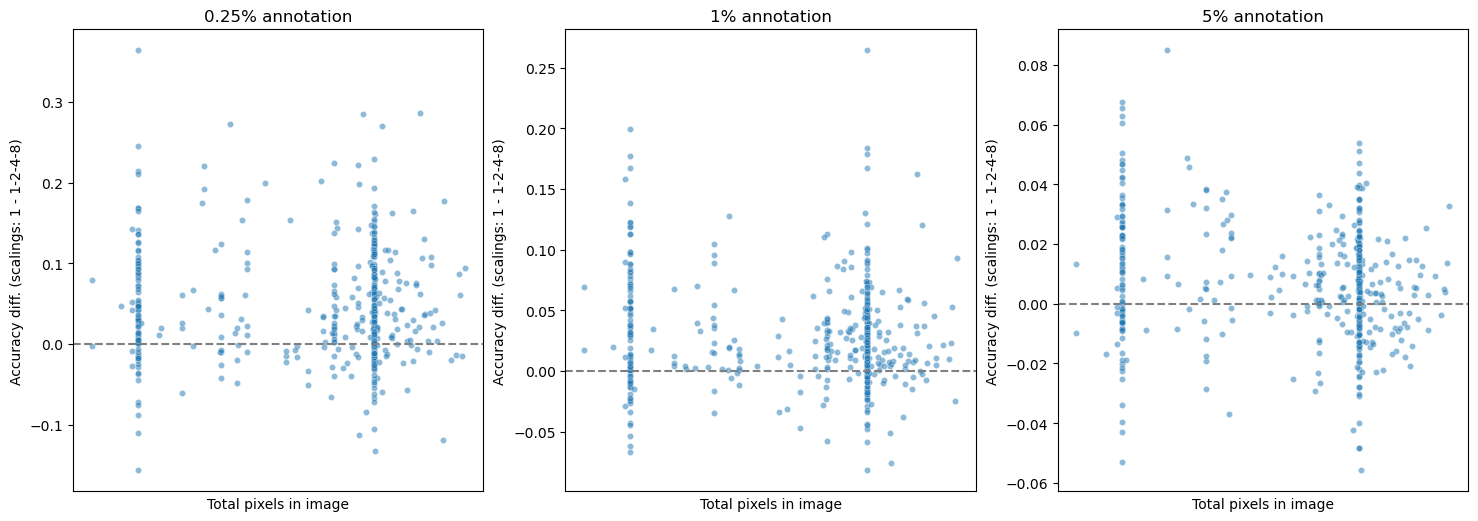

In [442]:
fig, ax = plt.subplots(1, num_df)
fig.set_size_inches(6 * num_df, 6)
fig.set_dpi(100)
for i, grouped_df in enumerate(grouped_dfs):
    sns.scatterplot(x='pix_in_img', y='accuracy_diff', data=grouped_df, s=20, alpha=0.5, ax=ax[i])
    # ax[i].set_xscale('log')
    # ax[i].set_yscale('log')
    ax[i].axhline(0, color='grey', linestyle='--')
    ax[i].set_xticks([])    
    ax[i].set_xlabel('Total pixels in image')
    ax[i].set_ylabel(f'Accuracy diff. (scalings: {scalings_to_comp[0]} - {scalings_to_comp[1]})')
    ax[i].set_title(f'{annot_bins[i]}% annotation')
plt.show()

# HEATMAPS for model comparison

### Different ConvPaint models (layers/scaling combinations)

In [471]:
# Define which dataframe to use
df = cellpose_df.copy()
# df = food_df.copy()

# Optionally filter before comparing prediciton types (e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# For each model, create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction type'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ilastik = [single_bin_df[single_bin_df['prediction type'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction type'].str.contains('dino')] for single_bin_df in bin_df_list]

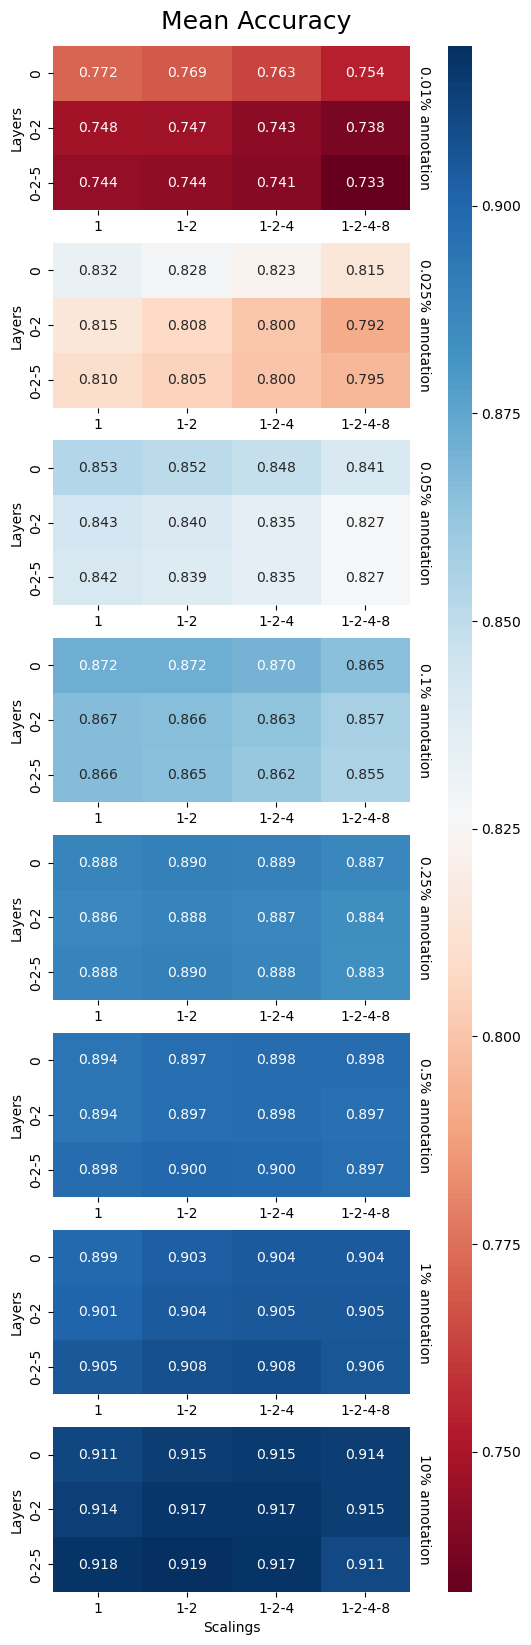

In [472]:
num_bins = len(annot_bins)
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values='accuracy').min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values='accuracy').max().max() for bin_df in bin_df_list_conv])
axis_matrix = [[str(bin), 'cbar'] for bin in annot_bins]
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [15, 1]})
ax_list = [ax[str(bin)] for bin in annot_bins]

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 12 * num_bins) * ratio # title + bottom + plot per bin
plot_width = 18 * (30) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle('Mean Accuracy', fontsize=18, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

for i, df in enumerate(bin_df_list_conv):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values='accuracy')
    sns.heatmap(heatmap_df_mean, annot=True, cmap="RdBu", fmt=".3f", cbar=i==0, cbar_ax=ax['cbar'], ax=row, vmin=min_val, vmax=max_val)
    row.text(1.02, 0.5, f'{annot_bins[i]}% annotation', transform=row.transAxes, rotation=270, va='center')
    row.set_xlabel('Scalings' if i == num_bins - 1 else '')
    row.set_ylabel('Layers')

    # row.set_aspect('auto')

# plt.savefig('FoodSeg103_results/avg_acc_convpaint.pdf', dpi=300)

### Convpaint models vs. Ilastik and DINOv2

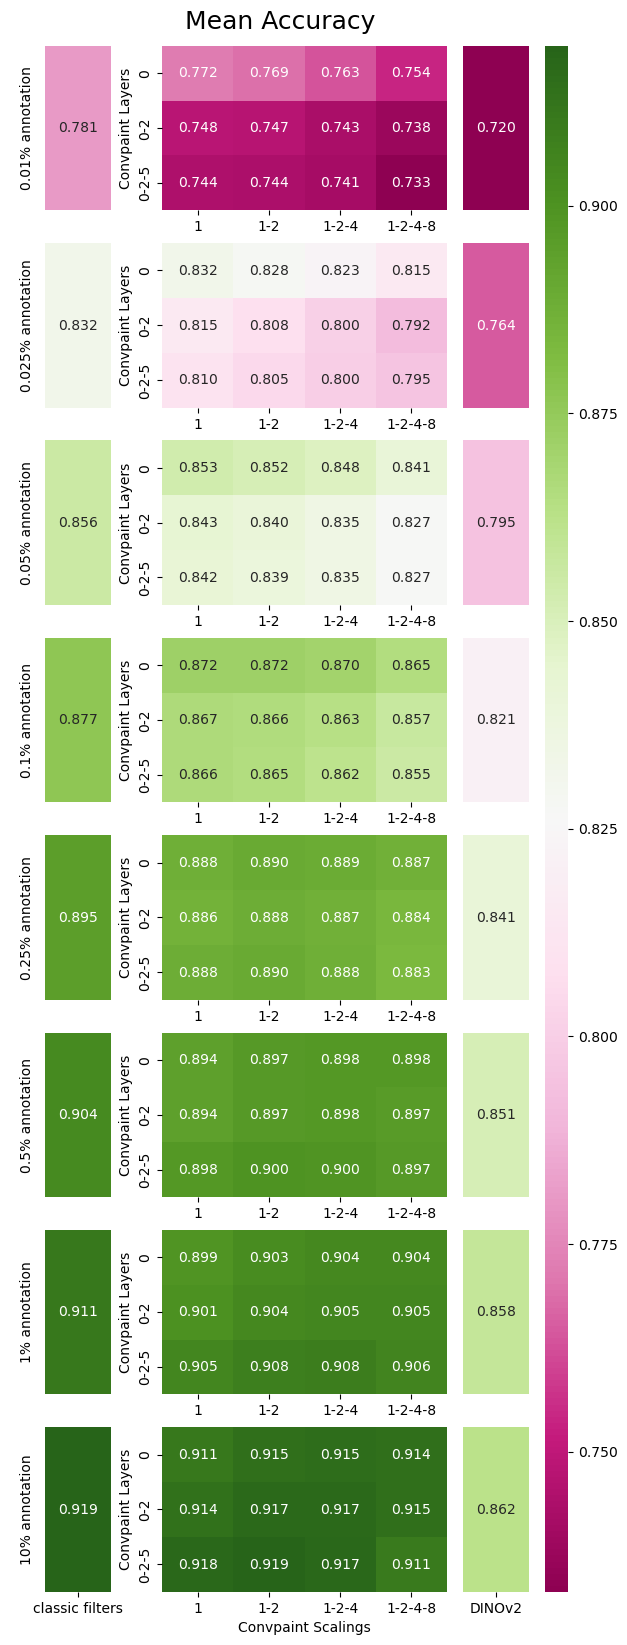

In [448]:
num_bins = len(annot_bins)
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values='accuracy').min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values='accuracy').max().max() for bin_df in bin_df_list_conv])

axis_matrix = np.array([['pad left', 
                          str(bin)+'ilastik', 
                          'pad', 
                          str(bin)+'convpaint', 
                          str(bin)+'dino', 
                          'cbar'] for bin in annot_bins])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [1, 3.5, 1, 15, 3.5, 1.2]})
for pad in ['pad left', 'pad']: ax[pad].axis('off')

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 12 * num_bins) * ratio # title + bottom + plot per bin
plot_width = 18 * (40) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle('Mean Accuracy', fontsize=18, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

heatmap_cfg = {"annot":True, "cmap":"PiYG", "fmt":".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}
# original cmap = 'YlGnBu'; good alternatives: twilight_shifted, RdBu, PuBuGn, PuBu, BuGn, PiYG

# CONVPAINT
ax_list_conv = [ax[ax_idx] for ax_idx in axis_matrix[:,3]]#[ax['upper left'], ax['mid left'], ax['lower left']]
for i, df in enumerate(bin_df_list_conv):
    row = ax_list_conv[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values='accuracy')
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('Convpaint Scalings' if i == num_bins - 1 else '')
    row.set_ylabel('Convpaint Layers')

# ILASTIK
ax_list_ila = [ax[ax_idx] for ax_idx in axis_matrix[:,1]] #[ax['upper mid'], ax['mid mid'], ax['lower mid']]
for i, df in enumerate(bin_df_list_ilastik):
    row = ax_list_ila[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df['accuracy'].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["classic filters"])
    else:
        row.set_xticks([])
    row.set_yticks([])
    row.text(-0.37, 0.5, f'{annot_bins[i]}% annotation', transform=row.transAxes, rotation=90, va='center')

# DINOv2
ax_list_dino = [ax[ax_idx] for ax_idx in axis_matrix[:,4]]
for i, df in enumerate(bin_df_list_dino):
    row = ax_list_dino[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df['accuracy'].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["DINOv2"])
    else:
        row.set_xticks([])
    row.set_yticks([])

# plt.savefig('cellpose_results/avg_acc.pdf', dpi=300)
# plt.savefig('FoodSeg103_results/avg_acc.pdf', dpi=300)